# Tutorial: Training U-Net Models for Chlorophyll a gap filling


### Library imports

In this tutorial, we will be using the following libraries:
- `import numpy as np`: NumPy is a fundamental library for scientific computing in Python. It provides support for multidimensional arrays, matrices, and many fast mathematical operations tomanipulate these data structures. We use NumPy for array operations and data processing. 
- `import dask.array as da`: Dask is a parallel computing library that handles large datasets, and dask array allows parallel computation coordinating a collection of NumPy arrays, which greatly improves efficiency. We use Dask array for more efficient computation of larger data.
- `import xarray as xr`: Xarray is designed for working with labeled multi-dimensional arrays, commonly used in scientific data analysis, particularly in fields like oceanography and climate science. It extends the capabilities of NumPy arrays by introducing labels of dimensions, coordinates, and attributes to the data. We use Xarray to create and manipulate datasets.
- `import zarr`: Zarr is a cloud-based data format for chunked, compressed, N-dimensional arrays. The library allows efficient storage and access of large datasets. We use Zarr to store Xarray datasets in the easily accessible Zarr format.


- `from os import path`: The OS library provides functions for interacting with the operating system, and the Path submodule is specifically useful in pathname manipulations. We use path to check whether a file or directory exists and avoid recomputations.

- `import matplotlib.pyplot as plt`: Matplotlib is a powerful plotting library, and the pyplot module introduces a collection of functions that allows MATLAB-like plotting. We use pyplot to visualize our data and results.

- `import tensorflow as tf`: Tensorflow is a machine learning framework for building and training deep learning neural network models. This library is the basis of building the U-Net model.
- `from keras import Input`: Keras is a high-level neural networks API that runs on top of tensorflow. Input is a tensor-like object that defines the attributes of the input data, such as shape and datatype. We also use it to create models with a defined output using `tf.keras.Model()`.
- `import keras.layers as layers`: The layers module provides various neural network layers, which are used for building the U-Net model.
- `from keras.callbacks import EarlyStopping`: Earlystopping is a regularization technique that monitors the model's performance during training and stops the training process when the model stops improving. We use earlystopping to improve efficiency and prevent overfitting.

- `import cartopy.crs as ccrs`: This module provides classes and functions to define and manipulate different coordinate reference systems (CRS). We use ccrs to define map projections (PlateCarree, or the equirectangular projection or geographic projection) and transfer the coordinates when plotting results.
- `import cartopy.feature as cfeature`: This module provides access to various geographical features like coastlines, borders, rivers, and landforms. These features can be added to maps to provide context or enhance the visualization. We use cfeature specifically for plotting coastlines during evaluation.

In [1]:
import numpy as np
import dask.array as da
import xarray as xr
import zarr

from os import path

import matplotlib.pyplot as plt

#import tensorflow as tf
#from keras import Input
#import keras.layers as layers
#from keras.callbacks import EarlyStopping

import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Check for Available GPUs

When training ConvLSTM models, using a GPU can significantly speed up the training process compared to using a CPU. The following code checks if your environment includes a GPU and uses it for training if available.  By default, TensorFlow will use the available GPU for training.


In [2]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

NameError: name 'tf' is not defined

In [1]:
datadir = "/home/jovyan/shared-public/mindthegap/data"

### Data Preprocessing
#### 1. Load the dataset
We start by loading the dataset of IO.zarr, slicing the region to the desired dimension, and removing days with no valid CHL data.

In [2]:
zarr_ds = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)

In [6]:
#zarr_ds = zarr_ds.sel(lat=slice(32, -11.75), lon=slice(42,101.75))  # choose long and lat

#all_nan_CHL = np.isnan(zarr_ds['CHL_cmes-level3']).all(dim=["lon", "lat"]).compute()  # find sample indices where CHL is NaN

#zarr_ds = zarr_ds.sel(time=(~all_nan_CHL))  # select samples with CHL not NaN

#zarr_ds = zarr_ds.sortby('time')

In [3]:
zarr_ds

<xarray.Dataset> Size: 66GB
Dimensions:                       (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                           (lat) float32 708B 32.0 31.75 ... -11.75 -12.0
  * lon                           (lon) float32 964B 42.0 42.25 ... 101.8 102.0
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 3GB ...
    CHL_cmes-cloud                (time, lat, lon) uint8 686MB ...
    CHL_cmes-gapfree              (time, lat, lon) float32 3GB ...
    CHL_cmes-land                 (lat, lon) uint8 43kB ...
    CHL_cmes-level3               (time, lat, lon) float32 3GB ...
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 3GB ...
    ...                            ...
    ug_curr                       (time, lat, lon) float32 3GB ...
    v_curr                        (time, lat, lon) float32 3GB ...
    v_wind                        (time, lat, lon) float32 3GB ...
    vg_curr                       (time, lat, lon) float32 3GB ...
    wind_dir                      (time, lat, lon) float32 3GB ...
    wind_speed                    (time, lat, lon) float32 3GB ...
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

#### 2. Process data

#### Function: `data_preprocessing`
This function selects and standardizes feature variables, and store them to a zarr file for easy access in future training and evaluation.

##### Parameters:
- `zarr_ds`: original zarr dataset after region slicing and NaN CHL filtering
- `features`: a list of features available directly from _zarr_ds_
- `train_year`: the first year of train data
- `train_range`: length of train data in year


##### Other Features (X):
- `sin_time`:
$
\sin({\text{day in the year} \over 366} \cdot 2 \pi)
$
for seasonal information
- `cos_time`:
$
\cos({\text{day in the year} \over 366} \cdot 2 \pi)
$
for seasonal information as well
- `masked_CHL` (logged): artifically masked CHL to simulate cloud coverage. Artificial clouds are the overlapping pixels of _current day observed CHL location_ and _10 day after cloud location_
- `prev_day_CHL`: CHL data from the previous day
- `next_day_CHL`: CHL data from the next day
- `land_flag`: flag for land, with 1 = land and 0 = not land
- `real_cloud_flag`: flag for real cloud, with 1 = real cloud and 0 = not real cloud
- `valid_CHL_flag`: flag for observed CHL after applying artifical masks, with 1 = CHL observed and 0 = CHL not observed
- `fake_cloud_flag`: flag for fake cloud, with 1 = fake cloud and 0 = not fake cloud

##### label (y):
- `CHL` (logged): observed CHL

##### Standardization:
First standardize based on train dataset, and then apply the calculated mean and standard deviation to all data. Only numerical features and the label are standardized. Mean and standard deviation of _CHL_ and _masked_CHL_ are stored in a `.npy` file for evaluation. 

#### Function: `create_zarr`
This function creates a zarr file and stores standardized features and label to the zarr file. 

__Note__: If you run the code for the first time (the `data_preprocessing` function creates the zarr file), it is recommended to restart the kernel and release the memory. Otherwise you might run out of memory during the trainning phase.

In [3]:
def data_preprocessing(zarr_ds, features, train_year, train_range):
    numer_features = []  # numerical features
    cat_features = []  # categorical features
    zarr_label = f'{train_year}_{train_range}'  # later passed to create_zarr as zarr file name
    zarr_label = f'{zarr_label}_full_2days'

    print('label created')

    if path.exists(f'{datadir}/{zarr_label}.zarr'):
        print('Zarr file exists')
        return zarr_label
    
    # add raw data features
    for feature in features:
        feat_arr = zarr_ds[feature].data
        numer_features.append(feat_arr)
    print('raw data features added')

    # get label
    CHL_data = zarr_ds['CHL_cmes-level3']
    CHL_data = np.log(CHL_data.copy())
    print('CHL logged')
    
    # additional features
    # sin and cos of day for seasonal features
    time_data = da.array(zarr_ds.time)
    day_rad = (time_data - np.datetime64("1900-01-01")) / np.timedelta64(1, "D") / 365 * 2 * np.pi
    day_rad = day_rad.astype(np.float32)
    day_sin = np.sin(day_rad)
    day_cos = np.cos(day_rad)
    print('sin and cos time calculated')
    day_sin = np.tile(day_sin[:, np.newaxis, np.newaxis], (1,) + CHL_data[0].shape)
    day_sin = da.rechunk(day_sin, (100, *day_sin.shape[1:]))
    numer_features.append(day_sin)
    print('sin time added')
    day_cos = np.tile(day_cos[:, np.newaxis, np.newaxis], (1,) + CHL_data[0].shape)
    day_cos = da.rechunk(day_cos, (100, *day_cos.shape[1:]))
    numer_features.append(day_cos)
    print('cos time added')

    
    # artifically masked CHL (10 day shift)
    day_shift_flag = np.vstack((zarr_ds['CHL_cmes-cloud'].data[10:], zarr_ds['CHL_cmes-cloud'].data[:10]))
    assert CHL_data.shape == day_shift_flag.shape
    
    masked_CHL = da.where(day_shift_flag == 0, np.nan, CHL_data)
    numer_features.append(masked_CHL)

    print('masked CHL added')

    prev_day = np.vstack((np.zeros((1, ) + CHL_data[0].shape), CHL_data.data[:-1]))
    numer_features.append(prev_day)
    print('prev day CHL added')
    next_day = np.vstack((CHL_data.data[1:], np.zeros((1, ) + CHL_data[0].shape)))
    numer_features.append(next_day)
    print('next day CHL added')

    # land one-hot encoding
    land_flag = da.zeros(CHL_data.shape)
    land_flag = da.where(zarr_ds['CHL_cmes-cloud'][0] == 2, 1, land_flag)
    cat_features.append(land_flag)
    
    print('land flag added')

    # real cloud one-hot encoding
    real_cloud_flag = da.zeros(CHL_data.shape)
    real_cloud_flag = da.where(zarr_ds['CHL_cmes-cloud'] == 1, 1, real_cloud_flag)
    cat_features.append(real_cloud_flag)

    print('real cloud flag added')

    # valid CHL one-hot encoding
    valid_CHL_flag = da.zeros(CHL_data.shape)
    valid_CHL_flag = da.where(~da.isnan(masked_CHL), 1, valid_CHL_flag)
    cat_features.append(valid_CHL_flag)

    print('valid CHL flag added')

    
    # fake cloud one-hot encoding
    fake_cloud_flag = da.zeros(CHL_data.shape)
    fake_cloud_flag = da.where((land_flag + real_cloud_flag + valid_CHL_flag) == 0, 1, fake_cloud_flag)
    cat_features.append(fake_cloud_flag)

    print('fake cloud flag added')


    # find train data start and end indices
    train_start_ind = np.where(zarr_ds.time.values == np.datetime64(f'{train_year}-01-01'))[0][0]
    train_end_ind = np.where(zarr_ds.time.values == np.datetime64(f'{train_year + train_range}-01-01'))[0][0]
    

    # get mean and stdev for numerical features
    feat_mean = []
    feat_stdev = []

    for feature in numer_features:
        feature_train = feature[train_start_ind: train_end_ind]
        feat_mean.append(da.nanmean(feature_train).compute())
        feat_stdev.append(da.nanstd(feature_train).compute())
        print('calculating mean and stdev...')

    # calculate standardized features
    numer_features_stdized = []
    feature_shape = numer_features[0].shape
    for feature, mean, stdev in zip(numer_features, feat_mean, feat_stdev):
        numer_features_stdized.append((feature - da.full(feature_shape, mean)) / da.full(feature_shape, stdev))
        print('standardizing...')

    # get mean and stdev for CHL
    CHL_mean = da.nanmean(CHL_data).compute()
    CHL_stdev = da.nanstd(CHL_data).compute()
    np.save(f'{datadir}/{zarr_label}.npy', {'CHL': np.array([CHL_mean, CHL_stdev]), 'masked_CHL': np.array([feat_mean[-3], feat_stdev[-3]])})

    # calculate standardized CHL
    CHL_data_stdized = (CHL_data - da.full(feature_shape, CHL_mean)) / da.full(feature_shape, CHL_stdev)

    print('all standardized')

    numer_var_names = features + ['sin_time', 'cos_time', 'masked_CHL', 'prev_day_CHL', 'next_day-CHL']
    cat_var_names = ['land_flag', 'real_cloud_flag', 'valid_CHL_flag', 'fake_cloud_flag']

    print('creating zarr')
    create_zarr(zarr_ds, numer_features_stdized, numer_var_names, cat_features, cat_var_names, CHL_data_stdized.data, zarr_label)

    del time_data, day_rad, day_sin, day_cos
    del feature, feat_arr
    del numer_features, numer_features_stdized, numer_var_names, cat_features, cat_var_names, CHL_data, CHL_data_stdized
    del feat_mean, feat_stdev
    
    return zarr_label


def create_zarr(zarr_ds, numer_features, numer_var_names, cat_features, cat_var_names, CHL_data, zarr_label):
    chunk_size = 100
    coord_names = ['time', 'lat', 'lon']
    coords = {coord_name: zarr_ds[coord_name] for coord_name in coord_names}
    
    numer_features_dict = {var_name: (coord_names, feature) for var_name, feature in zip(numer_var_names, numer_features)}
    cat_features_dict = {var_name: (coord_names, feature) for var_name, feature in zip(cat_var_names, cat_features)}
    label_dict = {'CHL': (coord_names, CHL_data)}
    print('variables dicts loaded')
    
    ds_numer = xr.Dataset(numer_features_dict, coords=coords)
    ds_cat = xr.Dataset(cat_features_dict, coords=coords)
    ds_label = xr.Dataset(label_dict, coords=coords)
    print('xarray datasets created')    

    for var in list(ds_numer.keys()):
        ds_numer[var]=ds_numer[var].chunk({"time": chunk_size}) 
    for var in list(ds_cat.keys()):
        ds_cat[var]=ds_cat[var].chunk({"time": chunk_size})
    for var in list(ds_label.keys()):
        ds_label[var]=ds_label[var].chunk({"time": chunk_size}) 
    print('chunked')

    store = zarr.DirectoryStore(f'{datadir}/{zarr_label}.zarr')
    ds_numer.to_zarr(store, mode='w')
    ds_cat.to_zarr(store, mode='a')
    ds_label.to_zarr(store, mode='a')

In [7]:
# create the zarr 
datafeatures = ['u_wind', 'v_wind', 'sst', 'air_temp']
train_year = 2015
train_range = 3
val_range = 1
test_range = 1

zarr_label = data_preprocessing(zarr_ds, features, train_year, train_range)

NameError: name 'data_preprocessing' is not defined

In [8]:
zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'{datadir}/{zarr_label}.zarr'))

NameError: name 'zarr_label' is not defined

#### Function: `data_split`
This function selects the train, validation, and test data from the standardized data and splits the features and label.
##### Parameters:
- `zarr_stdized`: Zarr file storing standardized features and label.
- `train_year`: the first year of train data
- `train_range`: length of train data in year
- `val_range`: length of validation data in year
- `test_range`: length of test data in year
##### Return:
- `X_train, X_val, X_test`: the predictor variables of the train/validation/test data
- `y_train, y_val, y_test`: the response variables of the train/validation/test data

In [5]:
def data_split(zarr_stdized, train_year, train_range, val_range, test_range):
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    
    zarr_train = zarr_stdized.sel(time=slice(f'{train_year}-01-01', f'{train_year+train_range}-01-01'))
    X_train = []
    for var in X_vars:
        var = zarr_train[var].to_numpy()
        X_train.append(np.where(np.isnan(var), 0.0, var))
    y_train = zarr_train.CHL.to_numpy()
    y_train = np.where(np.isnan(y_train), 0.0, y_train)
    X_train = np.array(X_train)
    X_train = np.moveaxis(X_train, 0, -1)
    del zarr_train
    
    zarr_val = zarr_stdized.sel(time=slice(f'{train_year+train_range}-01-01', f'{train_year+train_range+val_range}-01-01'))
    X_val = []
    for var in X_vars:
        var = zarr_val[var].to_numpy()
        X_val.append(np.where(np.isnan(var), 0.0, var))
    y_val = zarr_val.CHL.to_numpy()
    y_val = np.where(np.isnan(y_val), 0.0, y_val)
    X_val = np.array(X_val)
    X_val = np.moveaxis(X_val, 0, -1)
    del zarr_val
    
    zarr_test = zarr_stdized.sel(time=slice(f'{train_year+train_range+val_range}-01-01', f'{train_year+train_range+val_range+test_range}-01-01'))
    X_test= []
    for var in X_vars:
        var = zarr_test[var].to_numpy()
        X_test.append(np.where(np.isnan(var), 0.0, var))
    y_test = zarr_test.CHL.to_numpy()
    y_test = np.where(np.isnan(y_test), 0.0, y_test)
    X_test = np.array(X_test)
    X_test = np.moveaxis(X_test, 0, -1)
    del zarr_test, var

    return (X_train, y_train, 
            X_val, y_val,
            X_test, y_test)

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = data_split(zarr_stdized, train_year, train_range, val_range, test_range)

NameError: name 'zarr_stdized' is not defined

### 3. Build model: U-Net
#### What is U-Net?
U-Net is a Convolutional Neural Network (CNN) architecture. CNN is a type of deep learning model that is particularly effective for visual data and high dimensional data analysis. It is powerful in capturing spatial hierarchies and patterns, and is widely used in computer vision tasks.
U-Net follows an autoencoder architecture, where the encoder half down-samples input images progressively and extracts features, while the decoder half constructs predictions based on these features. It is effective and accurate with rather limited data.

#### Model Architectures
The model uses three encoder layers of filter sizes 64, 128, 256, and three decoder layers of filter sizes 128, 64, 1. Each encoder block consists of two `Conv2D` layers, one `MaxPool2D` layer, and one `BatchNormalization` layer. Each decoder block consists of one `Conv2DTranspose` layer, one `Concatenate` layer, two `Conv2D` layer, and one `BatchNormalization` layer. The output of the final decoder layer is the gap-filled prediction of Chl-a.
- `Conv2D`: applies 2D convolution operations to the input. These layers are for feature detection (lines, edges, objects, patterns, etc.) in the encoder half, and for making predictions in the decoder half.
  `filters`: number of output channels and the number of features detected.
  `kernel_size`: size of the filters. All filters in this model are of size 3x3.
  `padding`: adds extra pixels to the input images. Padding of `same` ensures the same output dimensions as the input.
  `activation`: introduces non-linearity to neural networks that differentiate NNs from linear models. All layers other than the final layer uses 'ReLU', which outputs the input directly if positive and 0 if non-positive. The final layer uses 'Linear' due to potential negative values in log(Chl-a) predictions.
- `MaxPooling2D`: downsamples the input by taking the maximum in a given window (default is 2x2). It reduces complexity for future computations while retaining the most significant features. The output dimension is half of the input.
- `BatchNormalization`: normalizes the input. It reduces overfitting and improves the generalizability of a model.
- `Conv2DTranspose`: performs a "reverse" convolution and upsamples the input. The output dimension doubles the input.
- `Concatenate`: merges the upsampled feature maps with the feature maps from the corresponding encoder. It retains the higher-resolution features that were lost during downsampling.

#### Model Compilation
We use `.compile()` to configure the model for training.
`optimizer`: adjusts the parameters of the model during training to minimize the loss. We use `Adam`, which is known for faster convergence with its adaptively adjustment of the learning rate.
`loss`: define the loss function the model aims to minimize. We use mean squared error (MSE) due to its simplicity and effectiveness in the task.
`metrics`: other metrics, such as error or accuracy, we wish to evaluate during training. We apply mean absolute error (MAE) as another evaluator for performance.

In [11]:
def UNet(input_shape):
    inputs = Input(shape=input_shape)
    
    x = inputs

    filters = [64, 128, 256]
    ec_images = []

    for filter in filters:
        ec_images.append(x)
        x = layers.Conv2D(filters=filter, 
                          kernel_size=(3, 3),  
                          padding='same',
                          activation='relu'
                         )(x)
        x = layers.Conv2D(filters=filter, 
                          kernel_size=(3, 3),  
                          padding='same',
                          activation='relu'
                         )(x)
        x = layers.MaxPooling2D()(x)
        x = layers.BatchNormalization()(x)

    for filter, ec_image in zip(filters[:-1][::-1], ec_images[::-1][:-1]):
        # x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
        
        x = layers.concatenate([x, ec_image])
        x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
        x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
        x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(filter, 3, 2, padding='same')(x)
    x = layers.concatenate([x, ec_images[0]])
    x = layers.Conv2D(filters=filter, 
                         kernel_size=(3, 3),  
                         padding='same',
                         activation='relu'
                         )(x)
    outputs = layers.Conv2D(filters=1,
                      kernel_size=(3,3),
                      padding='same',
                      activation='linear'
                     )(x)

    unet_model = tf.keras.Model(inputs, outputs, name='U-net')
    unet_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return unet_model

In [12]:
input_shape = X_train.shape[1:]
model = UNet(input_shape)
model.summary()

2024-08-15 20:16:46.671862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14782 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


Model: "U-net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 176, 240,  │          0 │ -                 │
│ (InputLayer)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 240,  │      7,552 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 176, 240,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 120,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 88, 120,   │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 88, 120,   │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 88, 120,   │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 44, 60,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 60,    │        512 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 44, 60,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 44, 60,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 22, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 30,    │      1,024 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 44, 60,    │    295,040 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 44, 60,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 44, 60,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 44, 60,    │    147,584 │ conv2d_6[0][0]  

 Total params: 2,157,825 (8.23 MB)

 Trainable params: 2,156,545 (8.23 MB)

 Non-trainable params: 1,280 (5.00 KB)

#### Model training
We use `tf.data.Dataset.from_tensor_slices()` to shuffle the train data and slice the train and validation data according the provided batch size.
We then define earlystopping that will stop the training process if the performance is not improving, and then start fitting the model. The MSE and MAE are printed for each training epoch, and their values are recorded by `history`.

In [13]:
# process train
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=512).batch(4)
# process val
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(4)

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stop])

2024-08-15 20:17:07.764167: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4819077120 exceeds 10% of free system memory.
2024-08-15 20:17:08.943467: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4819077120 exceeds 10% of free system memory.
2024-08-15 20:17:10.310297: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1607823360 exceeds 10% of free system memory.
2024-08-15 20:17:10.701161: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1607823360 exceeds 10% of free system memory.


Epoch 1/50


2024-08-15 20:17:11.011210: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4819077120 exceeds 10% of free system memory.
I0000 00:00:1723753036.087725     760 service.cc:145] XLA service 0x7f366c0035d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723753036.087779     760 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-15 20:17:16.316076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-15 20:17:17.121859: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  1/275 ━━━━━━━━━━━━━━━━━━━━ 1:31:32 20s/step - loss: 0.8141 - mae: 0.5788

I0000 00:00:1723753050.935366     760 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 532 bytes spill stores, 460 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_8', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_11', 184 bytes spill stores, 184 bytes spill loads

I0000 00:00:1723753050.943909     760 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 109ms/step - loss: 0.0891 - mae: 0.1562 - val_loss: 0.0241 - val_mae: 0.0729
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 0.0129 - mae: 0.0537 - val_loss: 0.0135 - val_mae: 0.0528
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 0.0102 - mae: 0.0464 - val_loss: 0.0119 - val_mae: 0.0484
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 0.0081 - mae: 0.0396 - val_loss: 0.0101 - val_mae: 0.0435
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 0.0072 - mae: 0.0364 - val_loss: 0.0094 - val_mae: 0.0404
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 0.0068 - mae: 0.0339 - val_loss: 0.0089 - val_mae: 0.0401
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.0067 - mae: 0.0339 - val_loss: 0.0084 - val_mae: 0.0353
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 0.0058 - mae: 0.0285 - val_loss: 0.0077 - val_mae: 0.0325
Epoch 9/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/s

In [ ]:
del train_dataset, val_dataset

#### Visualize losses
__Function__ `plot_losses`: Takes history as a parameter and plots the train and validation errors vs number of epochs (number of iterations for model training). This model evaluates the mean squared error and mean absolute error. 

In [7]:
def plot_losses(history):
    history_keys = list(history.history.keys())
    plot_num = len(history_keys) // 2
    plt.figure(figsize=(5 * plot_num, 4))
    for i in range(plot_num):
        plt.subplot(1, plot_num, i + 1)
        train_key = history_keys[i]
        val_key = history_keys[i + plot_num]
        plt.plot(history.history[train_key], label=f'Train {train_key}')
        plt.plot(history.history[val_key], label=f'Validation {val_key[4:]}')
        plt.title(train_key)
        plt.xlabel('Epoch')
        plt.ylabel(train_key)
        plt.legend(loc='upper right')
        plt.grid(True)
    plt.show()

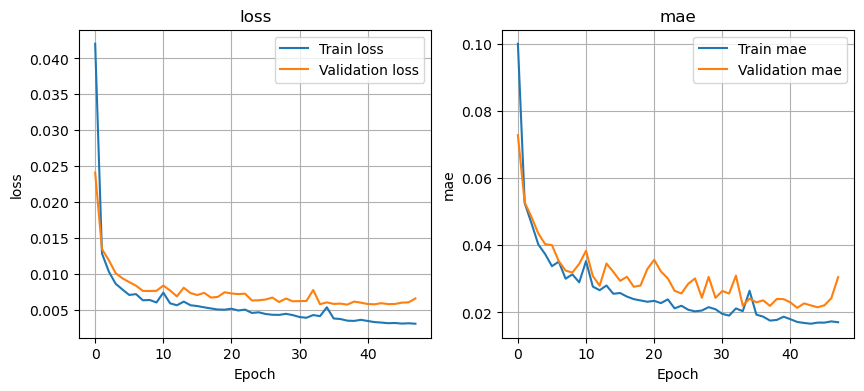

In [15]:
plot_losses(history)

#### Save trained model
The trained model is saved using `model.save` for easy access in future evaluation.
__Note__: Feel free to change the model path, but remember to create the folders before saving, or otherwise it may throw an error.

In [10]:
model_name = 'UNet_DoubleConv_mse'
model_path = f'models/{zarr_label}/{model_name}.keras'
model.save(model_path)

#### Reload trained model
If you want to reload a specific model, use `tf.kera.models.load_model` along with the path to the model.

In [11]:
model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')

2024-08-15 21:59:47.626092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14782 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


### 4. Model Evaluation
#### Evaluate test losses
__Function `test_loss`__: Takes the model and the test dataset as parameters and evaluates the model's performance. We use `model.evaluate` for performance of the model on unseen (test) dataset. The evaluation process calculates all loss and metrics compiled to the model (MAE and MSE in this case).

In [12]:
def test_loss(X_test, y_test, model, print_loss=True):
    # Prepare test dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(4)

    # Evaluate the model on the test dataset
    test_mse, test_mae = model.evaluate(test_dataset)
    if print_loss:
        print(f"Test MSE: {test_mse}")
        print(f"Test MAE: {test_mae}")
    return test_mse, test_mae

In [18]:
test_mse, test_mae = test_loss(X_test, y_test, model)

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0077 - mae: 0.0300
Test MSE: 0.008152502588927746
Test MAE: 0.03008805774152279


#### Helper functions
- `unstdize`: unstandardize a given image to the original distribution. Since we standardized all data before training, the predicted log(Chl-a) from the model is also standardized. We apply this function so that the predictions are more comparable to the observed and other gap-filling products.
- `compute_mae`: computes the mean absolute error between two nd-arrays with the same shape. We use this function to calculate the difference between observed and predicted, or predictions between different algorithms.
- `compute_mse`: similar to `compute_mae`, but calculates the mean squared error instead.

In [13]:
def unstdize(stdized_image, mean, stdev):
    return stdized_image * stdev + mean

def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

def compute_mse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean((y_true[mask] - y_pred[mask]) ** 2)

# def mean_error(y_true, y_pred):
#     mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
#     return np.abs(np.mean(y_true[mask]) - np.mean(y_pred[mask]))

#### Plot predictions
- `plot_prediction_observed`: predicts the observed log(chl-a) data of a given date. Plots a four-panel plot with the top left being the log observed data, top right being the flag, bottom left being the log prediction, and bottom right being the log difference. Log difference shows the percentage difference: blue/log(1) means the observed is about 2.7 times the prediction, red/log(-1) means the observed is about 37% of the prediction.

In [33]:
def plot_prediction_observed(zarr_stdized, zarr_label, model, date_to_predict):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    # true_CHL = unstdize(true_CHL, mean, std)
    fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    masked_CHL = np.where(fake_cloud_flag == 1, np.nan, true_CHL)
    # masked_CHL = unstdize(masked_CHL, mean, std)
    predicted_CHL = model.predict(X[np.newaxis, ...], verbose=0)[0]
    predicted_CHL = predicted_CHL[:,:,0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    diff = true_CHL - predicted_CHL

    flag = np.zeros(true_CHL.shape)
    flag = np.where(zarr_date['land_flag'] == 1, 0, flag)
    flag = np.where(zarr_date['valid_CHL_flag'] == 1, 2, flag)
    flag = np.where(zarr_date['real_cloud_flag'] == 1, 0, flag)
    flag = np.where(zarr_date['fake_cloud_flag'] == 1, 1, flag)

    vmax = np.nanmax((true_CHL, predicted_CHL))
    vmin = np.nanmin((true_CHL, predicted_CHL))

    extent = [42, 101.75, -11.75, 32]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    im0 = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree(), interpolation='nearest')
    axes[0, 0].add_feature(cfeature.COASTLINE)
    axes[0, 0].set_xlabel('longitude')
    axes[0, 0].set_ylabel('latitude')
    axes[0, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 0].set_title('Observed Level-3 log Chl-a', size=14)
    
    im1 = axes[0, 1].imshow(flag, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    axes[0, 1].add_feature(cfeature.COASTLINE, color='white')
    axes[0, 1].set_xlabel('longitude')
    axes[0, 1].set_ylabel('latitude')
    axes[0, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 1].set_title('Land, Cloud, and Observed Flags After Applying Fake Cloud', size=13)
    
    im2 = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree(), interpolation='nearest') 
    axes[1, 0].add_feature(cfeature.COASTLINE, color='white')
    axes[1, 0].imshow(np.where(flag == 1, np.nan, flag), vmax=2, vmin=0, extent=extent, origin='upper', interpolation='nearest', alpha=1)
    axes[1, 0].set_xlabel('longitude')
    axes[1, 0].set_ylabel('latitude')
    axes[1, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 0].set_title('Predicted log Chl-a from U-Net', size=14)

    vmin2 = -1
    vmax2 = 1
    im3 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu, interpolation='nearest')
    axes[1, 1].add_feature(cfeature.COASTLINE)
    axes[1, 1].set_xlabel('longitude')
    axes[1, 1].set_ylabel('latitude')
    axes[1, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 1].set_title('Difference Between log Observed and log Prediction\n(log observed - log prediction)', size=13)

    fig.subplots_adjust(right=0.76)
    cbar1_ax = fig.add_axes([0.79, 0.14, 0.025, 0.72])
    cbar1 = fig.colorbar(im0, cax=cbar1_ax)
    cbar1.ax.set_ylabel('log Chl-a (mg/m-3)', rotation=270, size=14, labelpad=16)

    cbar2_ax = fig.add_axes([0.86, 0.14, 0.025, 0.72])
    cbar2 = fig.colorbar(im1, cax=cbar2_ax)
    cbar2.ax.set_ylabel('land and real cloud = 0, fake cloud = 1, observed after masking = 2', rotation=270, size=14, labelpad=20)

    cbar3_ax = fig.add_axes([0.94, 0.14, 0.025, 0.72])
    cbar3 = fig.colorbar(im3, cax=cbar3_ax)
    cbar3.ax.set_ylabel('difference in log Chl-a', rotation=270, size=14, labelpad=16)
    plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


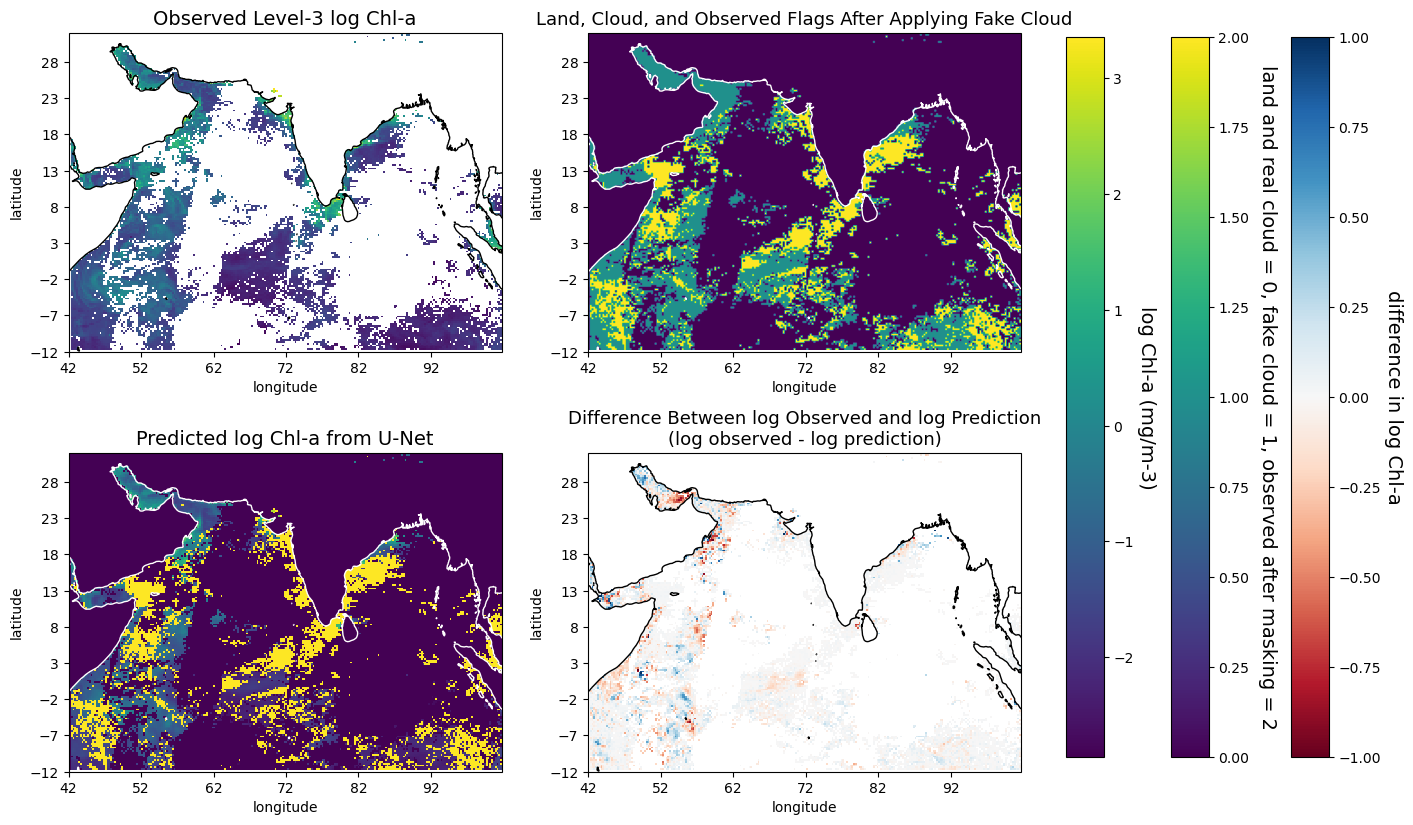

In [34]:
date = '2020-09-08'
plot_prediction_observed(zarr_stdized, zarr_label, model, date)

- `plot_prediction_gapfill`:  predicts the gapfilled log(chl-a) of a given date. Plots a four-panel plot with the top left being the log gapfilled data from Copernicus GlobColour gapfree product, top right being the log U-Net prediction, bottom left being the log difference, and bottom right being the absolute difference.

In [50]:
def plot_prediction_gapfill(zarr_stdized, zarr_label, model, date_to_predict):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    zarr_date = zarr_stdized.sel(time=date_to_predict)
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    
    for var in X_vars:
        var = zarr_date[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind])
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = X_masked_CHL

    
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-gapfree'].to_numpy())
    masked_CHL = np.log(zarr_ds.sel(time=date_to_predict)['CHL_cmes-level3'].to_numpy())
    predicted_CHL = model.predict(X[np.newaxis, ...], verbose=0)[0]
    predicted_CHL = predicted_CHL[:,:,0]
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(np.isnan(true_CHL), np.nan, predicted_CHL)
    log_diff = true_CHL - predicted_CHL
    diff = np.exp(true_CHL) - np.exp(predicted_CHL)

    vmax = np.nanmax((true_CHL, predicted_CHL))
    vmin = np.nanmin((true_CHL, predicted_CHL))

    extent = [42, 101.75, -11.75, 32]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    im0 = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    # axes[0, 0].add_feature(cfeature.COASTLINE)
    axes[0, 0].set_xlabel('longitude')
    axes[0, 0].set_ylabel('latitude')
    axes[0, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 0].set_title('Log Chl-a from the Gapfree \nLevel-4 GlobColour Copernicus Product', size=14)
    
    im1 = axes[0, 1].imshow(predicted_CHL, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    axes[0, 1].set_xlabel('longitude')
    axes[0, 1].set_ylabel('latitude')
    axes[0, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 1].set_title('Gapfree log Chl-a from U-Net', size=14)
    
    vmax2 = 1
    vmin2 = -1
    im2 = axes[1, 0].imshow(log_diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 0].add_feature(cfeature.COASTLINE)
    axes[1, 0].set_xlabel('longitude')
    axes[1, 0].set_ylabel('latitude')
    axes[1, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 0].set_title('Difference Between log Copernicus Product\nand log U-Net Prediction(log Copernicus - log U-Net)', size=13)

    im3 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 1].add_feature(cfeature.COASTLINE)
    axes[1, 1].set_xlabel('longitude')
    axes[1, 1].set_ylabel('latitude')
    axes[1, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 1].set_title('Absolute Difference Between Copernicus Product\nand U-Net Predictions(Copernicus - U-Net)', size=13)

    # fig.subplots_adjust(right=0.85)
    # cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    # fig.colorbar(im, cax=cbar_ax)

    # cbar2_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    # fig.colorbar(im2, cax=cbar2_ax)

    fig.subplots_adjust(right=0.85)
    cbar1_ax = fig.add_axes([0.87, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar1 = fig.colorbar(im0, cax=cbar1_ax)
    cbar1.ax.set_ylabel('log Chl-a (mg/m-3)', rotation=270, size=14, labelpad=16)

    cbar2_ax = fig.add_axes([0.94, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar2 = fig.colorbar(im2, cax=cbar2_ax)
    cbar2.ax.set_ylabel('difference in Chl-a in log or absolute scales', rotation=270, size=14, labelpad=16)
    plt.subplots_adjust(top=0.96)
    plt.show()

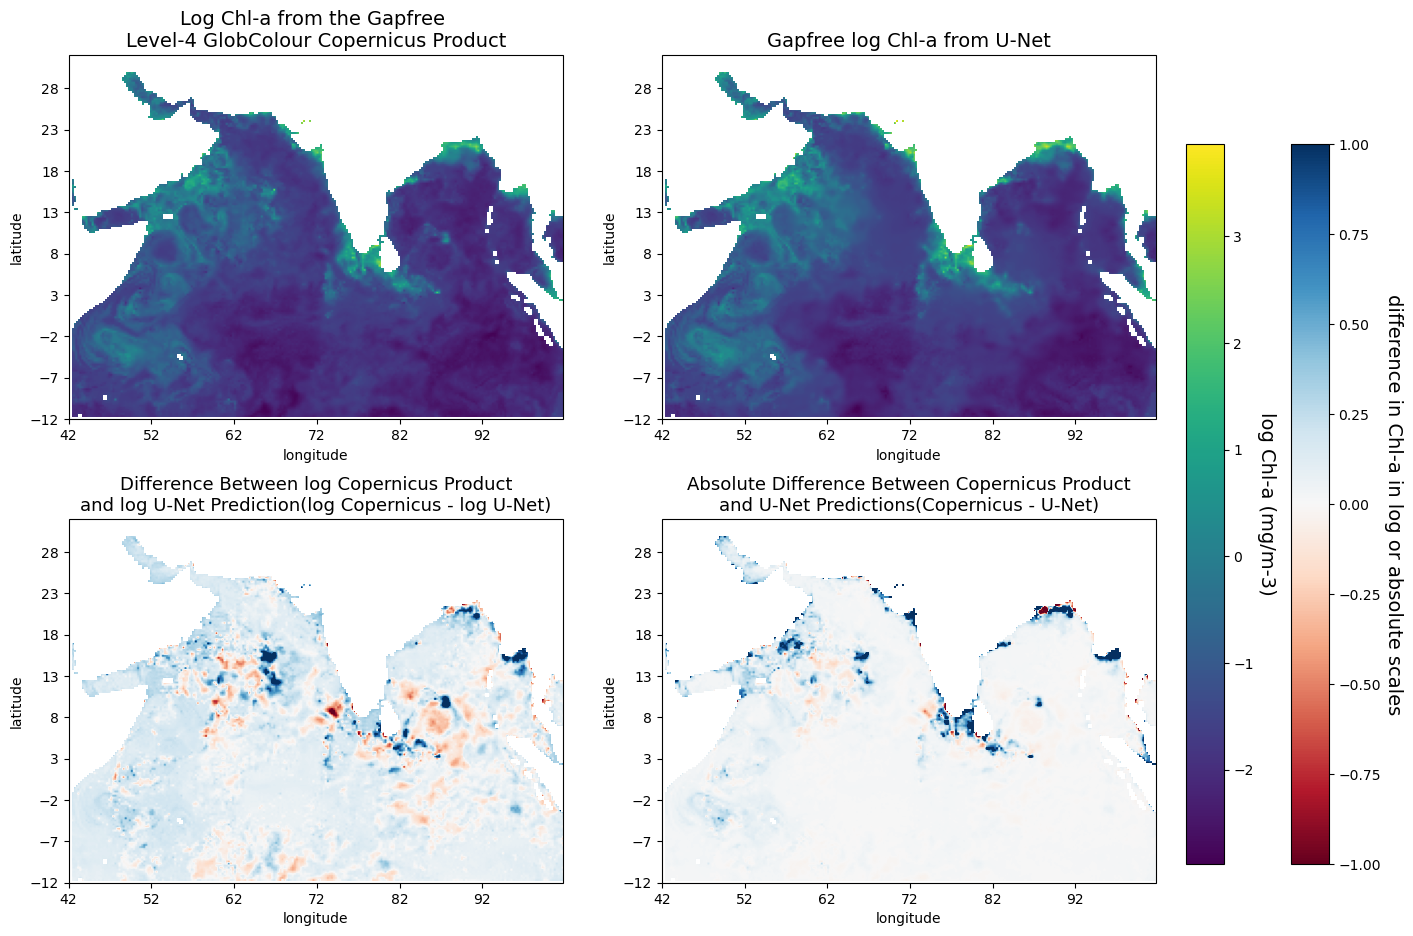

In [52]:
plot_prediction_gapfill(zarr_stdized, zarr_label, model, date)

#### Plot Year-round Mean Absolute Difference
Such plots help evaluate the performance of the model on a daily basis and visualize seasonal trends.
- `yearly_MAD`: plots a line plot of the daily MAD between the observed and the U-Net prediction of the observed in a given year. 

In [14]:
def yearly_MAD(zarr_stdized, zarr_label, year):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')
    zarr_time_range = zarr_stdized.sel(time=time_range)

    mae = []

    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    fake_cloud_flag = zarr_time_range.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l3) - log (U-Net)', color=color)
    ax1.plot(mae, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Observed (Level-3) CHL vs U-Net Predictions Year {year}')
    plt.xlim(1, len(mae))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


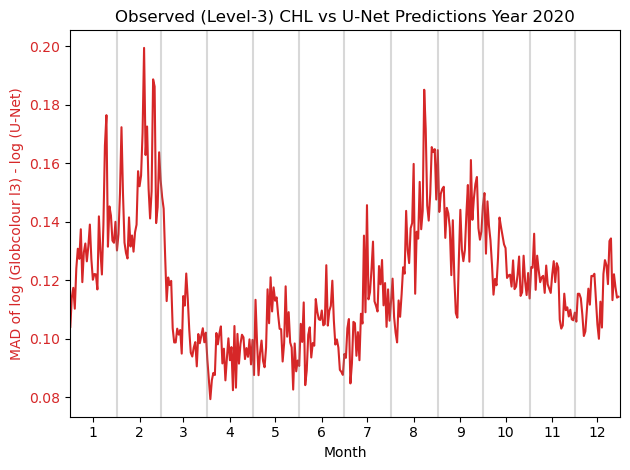

In [22]:
yearly_MAD(zarr_stdized, zarr_label, 2020)

- `yearly_MAD_vs_cloud`: plots a line plot with two lines: the red line is the daily MAD between the Copernicus Gapfree product and the U-Net's gapfree prediction in a given year, and the blue line is the daily percentage of cloud/missing data of the same year.
- `get_cloud_perc`: a helper function that gets the cloud percentage in a given year.|

In [23]:
def get_cloud_perc(zarr_stdized, year):
    zarr_time_range = zarr_stdized.sel(time=str(year))

    non_land_cnt = len(np.where(zarr_time_range['land_flag'][0] == 0)[0])
    clouds = zarr_time_range['real_cloud_flag'].data
    cloud_cnt = np.sum(clouds == 1, axis=(1, 2)).compute()
    cloud_perc = cloud_cnt / non_land_cnt

    return cloud_perc
    

def yearly_MAD_vs_cloud(zarr_stdized, zarr_label, model, year):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')

    zarr_time_range = zarr_stdized.sel(time=time_range)
    
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind]) 
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = da.where(da.isnan(X_masked_CHL), 0.0, X_masked_CHL)
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-gapfree'].to_numpy())            
    # fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    flag = zarr_ds.sel(time=str(year))['CHL_cmes-level3'].to_numpy()
    predicted_CHL = np.where(~np.isnan(flag), np.nan, predicted_CHL)
    mae = []
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
    
    cloud_perc = get_cloud_perc(zarr_stdized, year)
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l4) - log (U-Net)', color=color)
    ax1.plot(mae, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Cloud Percentage', color=color)  # we already handled the x-label with ax1
    ax2.plot(cloud_perc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Copernicus GlobColour Gapfree CHL vs U-Net Predictions\nMAD vs Cloud Percentage Year {year}')
    plt.xlim(1, len(mae))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

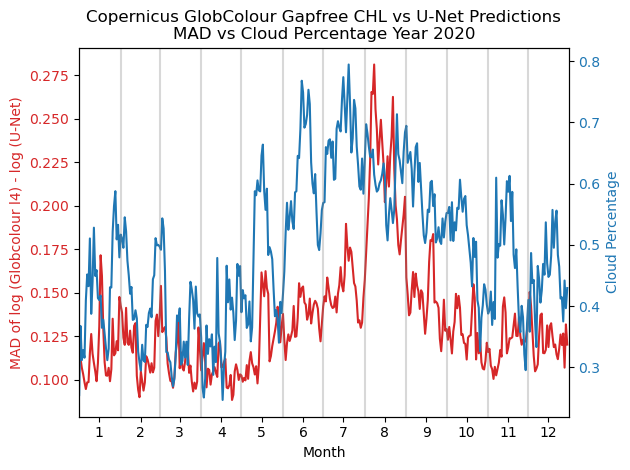

In [24]:
yearly_MAD_vs_cloud(zarr_stdized, zarr_label, model, 2020)